In [2]:
#!pip install gym
#!pip install torch
!pip install torchvision

  Using cached https://files.pythonhosted.org/packages/ca/0d/f00b2885711e08bd71242ebe7b96561e6f6d01fdb4b9dcf4d37e2e13c5e1/torchvision-0.2.1-py2.py3-none-any.whl
    100% |████████████████████████████████| 2.0MB 7.6MB/s eta 0:00:01


In [4]:
import random
import numpy as np
import sys
import gym
import torch
import pylab
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms


In [5]:
# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
torch.manual_seed(123)

class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [6]:
class Memory:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    #a = 0.6
    #beta = 0.4

    beta_increment_per_sampling = 0.000025

    def __init__(self, capacity, a, beta):
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.a = a
        self.beta = beta

    def _get_priority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []
        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/cecilia/miniconda3/envs/rl2018/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


[[-0.47348514 -0.00668942]]
episode: 0   score: -200.0   memory length: 200   epsilon: 1  beta 0.0001
[[-0.42461862  0.00988408]]
episode: 1   score: -200.0   memory length: 400   epsilon: 1  beta 0.0001
[[-0.66470931  0.0064344 ]]
episode: 2   score: -200.0   memory length: 600   epsilon: 1  beta 0.0001
[[-0.78751868 -0.00281763]]
episode: 3   score: -200.0   memory length: 800   epsilon: 1  beta 0.0001
[[-0.41740868 -0.00886999]]
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.99905  beta 0.000125
[[-0.46790557  0.00859812]]
episode: 5   score: -200.0   memory length: 1200   epsilon: 0.8090499999999987  beta 0.005124999999999983
[[-0.61982024 -0.00738196]]
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.6190499999999974  beta 0.010125000000000033
[[-0.76594592  0.01228283]]
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.42904999999999616  beta 0.015125000000000176
[[-0.46872643  0.00351455]]
episode: 8   score: -200.0   memory length: 1800  

[[0.50022556 0.03891899]]
episode: 63   score: -179.0   memory length: 11265   epsilon: 0.0499999999999937  beta 0.25674999999997583
[[0.50121046 0.04051901]]
episode: 64   score: -141.0   memory length: 11406   epsilon: 0.0499999999999937  beta 0.26027499999997544
[[0.54237467 0.04278245]]
episode: 65   score: -146.0   memory length: 11552   epsilon: 0.0499999999999937  beta 0.26392499999997504
[[0.52587942 0.04376877]]
episode: 66   score: -158.0   memory length: 11710   epsilon: 0.0499999999999937  beta 0.2678749999999746
[[0.52936026 0.03927924]]
episode: 67   score: -187.0   memory length: 11897   epsilon: 0.0499999999999937  beta 0.2725499999999741
[[0.50501464 0.0071409 ]]
episode: 68   score: -148.0   memory length: 12045   epsilon: 0.0499999999999937  beta 0.2762499999999737
[[-0.38453136 -0.06642014]]
episode: 69   score: -200.0   memory length: 12245   epsilon: 0.0499999999999937  beta 0.28124999999997313
[[0.51749783 0.0441935 ]]
episode: 70   score: -149.0   memory length:

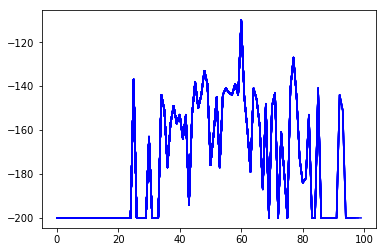

In [10]:
EPISODES = 100

# approximate Q function using Neural Network
# state is input and Q Value of each action is output of network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, action_size)
        )

    def forward(self, x):
        return self.fc(x)


# DQN Agent for the Cartpole
# it uses Neural Network to approximate q function
# and prioritized experience replay memory & target q network
class DQNAgent():
    def __init__(self, state_size, action_size, a, beta):
        # if you want to see Cartpole learning, then change to True
        self.render = True
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.8
        self.learning_rate = 0.001
        self.memory_size = 20000
        self.epsilon = 1
        self.epsilon_min = 0.05
        self.explore_step = 1000
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.explore_step
        self.batch_size = 64
        self.train_start = 1000

        # create prioritized replay memory using SumTree
        self.memory = Memory(self.memory_size, a, beta)

        # create main model and target model
        self.model = DQN(state_size, action_size)
        self.model.apply(self.weights_init)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=self.learning_rate)

        # initialize target model
        self.update_target_model()

        if self.load_model:
            self.model = torch.load('save_model/cartpole_dqn')

    # weight xavier initialize
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            torch.nn.init.xavier_uniform(m.weight)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.from_numpy(state)
            state = Variable(state).float().cpu()
            q_value = self.model(state)
            _, action = torch.max(q_value, 1)
            return int(action)

    # save sample (error,<s,a,r,s'>) to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        target = self.model(Variable(torch.FloatTensor(state))).data
        old_val = target[0][action]
        target_val = self.target_model(Variable(torch.FloatTensor(next_state))).data
        if done:
            target[0][action] = reward
        else:
            target[0][action] = reward + self.discount_factor * torch.max(target_val)

        error = abs(old_val - target[0][action])

        self.memory.add(error, (state, action, reward, next_state, done))

    # pick samples from prioritized replay memory (with batch_size)
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

        mini_batch, idxs, is_weights = self.memory.sample(self.batch_size)
        mini_batch = np.array(mini_batch).transpose()

        states = np.vstack(mini_batch[0])
        actions = list(mini_batch[1])
        rewards = list(mini_batch[2])
        next_states = np.vstack(mini_batch[3])
        dones = mini_batch[4]

        # bool to binary
        dones = dones.astype(int)

        # Q function of current state
        states = torch.Tensor(states)
        states = Variable(states).float()
        pred = self.model(states)

        # one-hot encoding
        a = torch.LongTensor(actions).view(-1, 1)

        one_hot_action = torch.FloatTensor(self.batch_size, self.action_size).zero_()
        one_hot_action.scatter_(1, a, 1)

        pred = torch.sum(pred.mul(Variable(one_hot_action)), dim=1)

        # Q function of next state
        next_states = torch.Tensor(next_states)
        next_states = Variable(next_states).float()
        next_pred = self.target_model(next_states).data

        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        # Q Learning: get maximum Q value at s' from target model
        target = rewards + (1 - dones) * self.discount_factor * next_pred.max(1)[0]
        target = Variable(target)

        errors = torch.abs(pred - target).data.numpy()

        # update priority
        for i in range(self.batch_size):
            idx = idxs[i]
            self.memory.update(idx, errors[i])

        self.optimizer.zero_grad()

        # MSE Loss function
        is_weights = torch.from_numpy(is_weights).type(torch.FloatTensor)
        loss = F.mse_loss(is_weights* pred, is_weights* target)
        #loss = F.mse_loss(pred, target)
        loss.backward()

        # and train
        self.optimizer.step()



        
if __name__ == "__main__":
    # In case of CartPole-v1, maximum length of episode is 500
    #env = gym.make('CartPole-v0')
    env = gym.make('MountainCar-v0')
    state_size = env.observation_.shape[0]
    action_size = env.action_space.n
    model = DQN(state_size, action_size)

    agent = DQNAgent(state_size, action_size, 0.6, 0.0001)
    #agent1 = DQNAgent(state_size, action_size, 0,  1.0)
    scores, episodes = [], []
    success = 0
    
    for e in range(EPISODES):
        done = False
        score = 0
        
        state = env.reset()        
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            #reward = reward if not done or score == 499 else -10
            reward = reward 
            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            # every time step do the training
            if agent.memory.tree.n_entries >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # every episode, plot the play time
                #score = score if score == 500 else score + 10
                print(state)
                if np.absolute(state[0][0]-0.5) < 0.05:
                    success+=1
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                #pylab.savefig("./save_graph/cartpole_dqn.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      agent.memory.tree.n_entries, "  epsilon:", agent.epsilon, " beta", agent.memory.beta)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                #if np.mean(scores[-min(10, len(scores)):]) > 490:
                    #torch.save(agent.model, "./save_model/cartpole_dqn")
                    #sys.exit()

In [ ]:

if __name__ == "__main__":
    # In case of CartPole-v1, maximum length of episode is 500
    #env = gym.make('CartPole-v0')
    env = gym.make('MountainCar-v0')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    model = DQN(state_size, action_size)

    #agent = DQNAgent(state_size, action_size, 0.6, 0.4)
    agent = DQNAgent(state_size, action_size, 0,  1.0)
    scores1, episodes1 = [], []

    for e in range(EPISODES):
        done = False
        score1 = 0
        
        state = env.reset()        
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            #reward = reward if not done or score == 499 else -10
            reward = reward 
            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            # every time step do the training
            if agent.memory.tree.n_entries >= agent.train_start:
                agent.train_model()

            score1 += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # every episode, plot the play time
                #score = score if score == 500 else score + 10
                scores1.append(score1)
                episodes1.append(e)
                pylab.plot(episodes1, scores1, 'b', episodes, scores, 'r')
                #pylab.savefig("./save_graph/cartpole_dqn.png")
                print("episode:", e, "  score:", score1, "  memory length:",
                      agent.memory.tree.n_entries, "  epsilon:", agent.epsilon)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                #if np.mean(scores[-min(10, len(scores)):]) > 490:
                    #torch.save(agent.model, "./save_model/cartpole_dqn")
                    #sys.exit()

In [12]:
success

51